In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests
import pingouin as pg 
import scipy.stats as stats
import numpy as np

from datetime import datetime
from urllib.parse import urlencode
from tqdm.auto import tqdm

%matplotlib inline

---
## Задание 1. Retantion.

Retention rate (Коэффициент удержания) — один из самых важных показателей в компании.

---

### Задача:

Написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

---

In [2]:
# Загрузка данных
df_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
df_auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
# Проверяем инфо
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [4]:
df_auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [5]:
df_auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [6]:
df_reg.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [7]:
# Сколько имеется уникальных регистраций.
df_reg.uid.nunique()

1000000

Мы проверили данные. Данные оказались чистыми. 
Однако, колонки с датами в формате timestamp. Переведём их в формат _datetime64_

In [8]:
df_reg['reg_ts'] = pd.to_datetime(df_reg['reg_ts'], unit='s')
df_auth['auth_ts'] = pd.to_datetime(df_auth['auth_ts'], unit='s')

---

In [9]:
# Соединяем два датафрейма в один.
df_merge = df_reg.merge(df_auth, how='left', on='uid')

In [10]:
df_merge.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [11]:
# Проверим тип данных в датафрейме
df_merge.dtypes

reg_ts     datetime64[ns]
uid                 int64
auth_ts    datetime64[ns]
dtype: object

In [12]:
df_merge

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39
...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31


Колонки с датой приведены в воспринимаемый нашим мозгом вид.

Далее были объединены два датасета для дальнейшей работы над функцией, которая будет рассчитывать Retention.

---

### Как работает функция?

1. Ввести начальную дату регистрации пользователей в формате год, месяц, день (YYYY-MM-DD);
2. Ввести конечную дату регистрации пользователей в формате год, месяц, день (YYYY-MM-DD);

---

In [13]:
def get_retention(df_merge):
    '''start — первая дата регистрации
end — вторая дата регистрации
Функция выводит heatmap с показателями Retention Rate (коэф. удержания)'''
    start = datetime.strptime(input('Enter the start date of registration in the format YYYY-MM-DD: '), '%Y-%m-%d') \
                    .date()
    end = datetime.strptime(input('Enter the end date of registration in the format YYYY-MM-DD: '), '%Y-%m-%d') \
                  .date()
    print(f'Retention from {start} to {end}.')
    
    
    # Фильтрация периодов для вычисления коэф. удержания
    df_merge = df_merge.query("reg_ts >= @start and reg_ts <= @end")
    df_merge = df_merge.query("auth_ts >= @start and auth_ts <= @end")
    
    
    # Рассчёт разницы между регистрацией и повторной авторизацией
    df_merge['difference'] = (df_merge.auth_ts - df_merge.reg_ts).dt.days
    
    
    # Приведение колонок к формату YYYY-MM-DD (сейчас в данных время записано в формате YYYY-MM-DDThh:mm:ss)
    df_merge['reg_ts'] = df_merge.reg_ts.dt.date
    df_merge['auth_ts'] = df_merge.auth_ts.dt.date
    
    
    # Группировка по дате регистрации и разницей между датой регистрации и повторной авторизацией
    df_merge = df_merge.groupby(['reg_ts', 'difference']).uid.nunique().reset_index() 
    
    
    # Деление на когорты
    cohort_table = df_merge.pivot_table(columns='difference', index='reg_ts', values='uid')
    
    
    # Счёт коэф. удержания
    retention = round(cohort_table.div(cohort_table[0], axis=0) * 100, 1).iloc[:-1, 1:]
    cohort = cohort_table.iloc[:, 0]
    retention.insert(loc=0, column='cohort', value=cohort)
    
    
    # Визуализазиция результата на тепловой карте
    plt.figure(figsize=(16, 9))
    retention = sns.heatmap(retention,
                            linewidths=1,
                            annot=True,
                            cmap='flare',
                            vmin=0, vmax=10, center=5,
                            fmt='g',
                            annot_kws={"fontsize": 9})
    plt.title('Retention rate', fontsize=14)
    plt.xlabel('Количество дней с даты регистрации', fontsize=12)
    plt.ylabel('Дата регистрации', fontsize=12)
    plt.yticks(rotation=0)
    plt.show()
    
    return retention

In [14]:
print(get_retention.__doc__)

start — первая дата регистрации
end — вторая дата регистрации
Функция выводит heatmap с показателями Retention Rate (коэф. удержания)


Enter the start date of registration in the format YYYY-MM-DD: 2020-07-01
Enter the end date of registration in the format YYYY-MM-DD: 2020-07-28
Retention from 2020-07-01 to 2020-07-28.


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

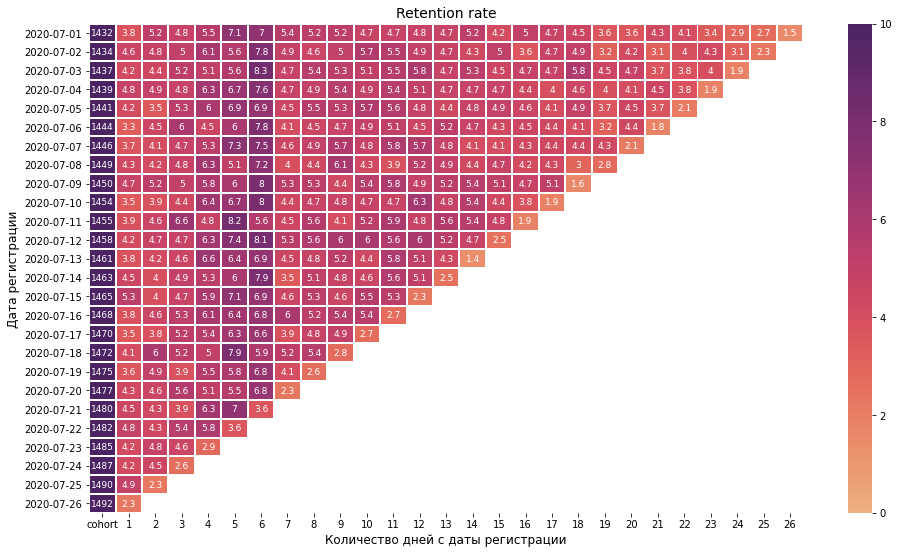

In [15]:
get_retention(df_merge)

### Вывод
Из полученных результатов исследований наблюдаем следующую картину.
Пик повторной авторизации в большинстве случаев порисходил на шестой день после регистрации, после чего шёл на спад. Однако в некоторые дни, зарегистрировавшиеся в одну дату заходили больше среднего.

---
## Задание 2. A/B-Tests.


Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

---

### Вопрос
Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

---

In [16]:
# Загрузка данных из интернета
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/d/SOkIsD5A8xlI7Q'

final_url = base_url + urlencode(dict(public_key=public_key)) 
request = requests.get(final_url)
download_link = json.loads(request.text)['href']

ab_tests_df = pd.read_csv(download_link, sep=';')
ab_tests_df.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [17]:
# Проверяем инфо
ab_tests_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [18]:
# Проверяем на наличие NaN в данных
ab_tests_df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

In [19]:
# Проверяем уникальные значения в данных
ab_tests_df.nunique()

user_id      404770
revenue        1477
testgroup         2
dtype: int64

In [20]:
# Проверяем общие значения по колонке 'revenue'
ab_tests_df.revenue.describe().round(1)

count    404770.0
mean         26.1
std         681.7
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       37433.0
Name: revenue, dtype: float64

In [21]:
# Проверяем значения revenue в контрольной группе
ab_tests_df.query('testgroup == "a"').revenue.describe().round(1)

count    202103.0
mean         25.4
std         920.8
min           0.0
25%           0.0
50%           0.0
75%           0.0
max       37433.0
Name: revenue, dtype: float64

In [22]:
# Проверяем значения revenue в тестовой группе
ab_tests_df.query('testgroup == "b"').revenue.describe().round(1)

count    202667.0
mean         26.8
std         287.3
min           0.0
25%           0.0
50%           0.0
75%           0.0
max        4000.0
Name: revenue, dtype: float64

In [23]:
ab_tests_df

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b
...,...,...,...
404765,404766,0,a
404766,404767,0,b
404767,404768,231,a
404768,404769,0,a


---

In [24]:
# Разделение датафрейма на две части, контрольную и тестовую
control_group = ab_tests_df.query('testgroup == "a"')
test_group = ab_tests_df.query('testgroup == "b"')

In [25]:
# Контрольная группа
control_group

,user_id,revenue,testgroup
1,2,0,a
2,3,0,a
9,10,0,a
10,11,0,a
11,12,0,a
...,...,...,...
404760,404761,0,a
404762,404763,0,a
404765,404766,0,a
404767,404768,231,a


In [26]:
# Тестовая группа
test_group

,user_id,revenue,testgroup
0,1,0,b
3,4,0,b
4,5,0,b
5,6,0,b
6,7,0,b
...,...,...,...
404761,404762,0,b
404763,404764,0,b
404764,404765,0,b
404766,404767,0,b


In [27]:
# ARPU (средний доход на юзера) тест
ARPU = ((test_group.revenue.sum() - control_group.revenue.sum()) / control_group.revenue.sum()) * 100
ARPU.round(2)

5.56

In [28]:
# Общая выручка
revenue_sum_control = control_group.revenue.sum()
revenue_sum_test = test_group.revenue.sum()


# Количество юзеров
users_control = control_group.user_id.count()
users_test = test_group.user_id.count()


# Количество донатеров (платящих игроков)
donate_control = control_group.query('revenue != 0').user_id.count()
donate_test = test_group.query('revenue != 0').user_id.count()


# Средний чек
avg_check_control = round(control_group.query('revenue != 0').revenue.mean(), 2)
avg_check_test = round(test_group.query('revenue != 0').revenue.mean(), 2)


# Медианный чек
median_check_control = control_group.revenue.median()
median_check_test = test_group.revenue.median()


# Коэф. конверсии. Conversion rate (CR)
CR_control = round(donate_control / users_control * 100, 2)
CR_test = round(donate_test / users_test * 100, 2)


# Средний доход на платящего пользователя (ARPPU)
arppu_control = round(revenue_sum_control / donate_control, 2)
arppu_test = round(revenue_sum_test / donate_test, 2)


# Средний доход на пользователя (ARPU)
arpu_control = round(revenue_sum_control / users_control, 2)
arpu_test = round(revenue_sum_test / users_test, 2)


# Общая таблица с метриками
all_metrics = pd.DataFrame({'user_count': [users_control, users_test],
                            'donaters_count': [donate_control, donate_test],
                            'CR': [CR_control, CR_test],
                            'avg_check': [avg_check_control, avg_check_test],
                            'median_check': [median_check_control, median_check_test],
                            'ARPPU': [arppu_control, arppu_test],
                            'ARPU': [arpu_control, arpu_test],
                            'revenue_sum': [revenue_sum_control, revenue_sum_test]},
                           index=['control', 'test'])

In [29]:
all_metrics

,user_count,donaters_count,CR,avg_check,median_check,ARPPU,ARPU,revenue_sum
control,202103,1928,0.95,2664.00,0.0,2664.00,25.41,5136189
test,202667,1805,0.89,3003.66,0.0,3003.66,26.75,5421603


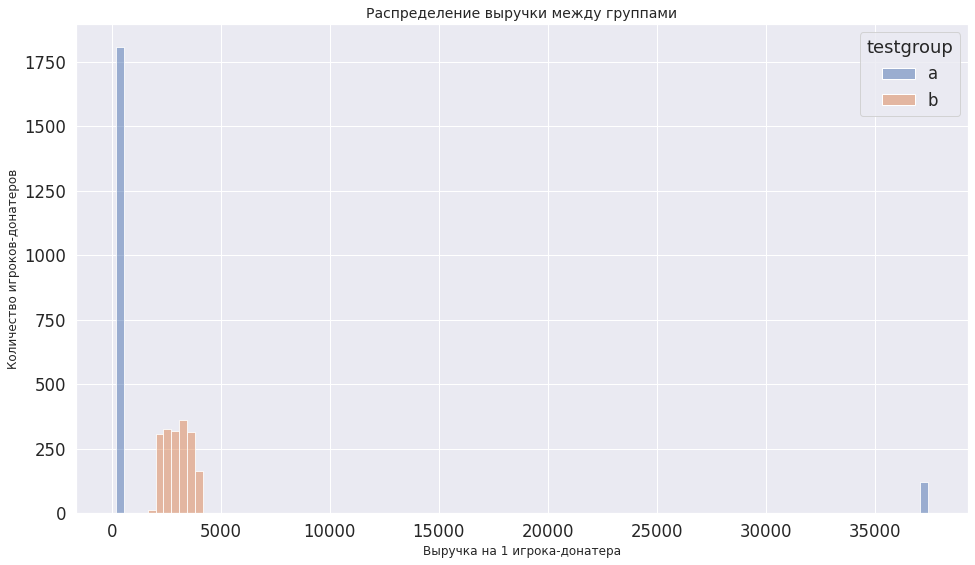

In [30]:
# График распределения прибыли по группам
plt.figure(figsize=(16, 9))
sns.set(font_scale=1.5)
sns.histplot(x='revenue', data=ab_tests_df.query('revenue != 0'), hue='testgroup')
plt.title('Распределение выручки между группами', fontsize=14)
plt.xlabel('Выручка на 1 игрока-донатера', fontsize=12)
plt.ylabel('Количество игроков-донатеров', fontsize=12)
plt.yticks(rotation=0)
plt.show()

---

### Расчёт стат. значимости

---

#### ARPU

Посмотрим одинаковы ли дисперсии внутри наших групп.

In [31]:
stats.levene(ab_tests_df.query('testgroup == "a"').revenue, 
             ab_tests_df.query('testgroup == "b"').revenue,
             center='mean') 

LeveneResult(statistic=1.57736044973474, pvalue=0.2091420343022563)

In [32]:
stats.levene(ab_tests_df.query('testgroup=="a"').revenue,
             ab_tests_df.query('testgroup=="b"').revenue,
             center='median') 

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

Значение p-value > 0.05, значит дисперсии гомогенны.

---
Для применения t-теста также необходимо соблюсти требование к нормальности данных в обоих группах, но при гомогенности дисперсии и большом размере выборок для этого требования можно сделать исключение.

In [33]:
def ttests():
    ttest = pg.ttest(x=ab_tests_df[ab_tests_df.testgroup == 'a'].revenue,
                     y=ab_tests_df[ab_tests_df.testgroup == 'b'].revenue)
    if ttest['p-val'].sum() > 0.05:
        result = print(f"Значение p-value = {ttest['p-val'].sum().round(2)}.\n\
Значение больше 0.05. Это значит, что мы принимаем нулевую гипотезу.\n\
Существенных различий между группами нет.")
    else:
        result = print(f"Значение p-value = {ttest['p-val'].sum().round(2)}. \n\
Значение меньше или равно 0.05. Это значит, что мы не принимаем нулевую гипотезу.\n\
Между группами есть существенные различия.")
    return result

In [34]:
ttests()

Значение p-value = 0.53.
Значение больше 0.05. Это значит, что мы принимаем нулевую гипотезу.
Существенных различий между группами нет.


---
#### ARPPU

In [35]:
control_PU = control_group.query('revenue > 0')
test_PU = test_group.query('revenue > 0')

In [36]:
stats.levene(control_PU.revenue, test_PU.revenue, center='mean')

LeveneResult(statistic=445.9869447066088, pvalue=1.3202514573715939e-93)

p-value < 0.05 
Дисперсии не гомогенны. t-критерий Стьюдента применять нельзя.

Тут нам поможет bootstrap.

---
#### Bootstrap

Функция поможет нам провести тест заданное количество раз и поможет сделать распределение нормальным.

Также она поможет нам определить приблизительное p-value, на основе которого мы сможем получить окончательный вывод A/B тестов.

In [37]:
def get_bootstrap(boot_num):
    
    # Уровень значимости
    bootstrap_conf_level = 0.95
    # Пустая переменная для записи результата
    boot_data = []
    
    # Извлекаем подвыборки
    for i in tqdm(range(boot_num)):
        sample_1 = control_PU.revenue \
                             .sample(len(control_PU), replace=True) \
                             .values        
        
        sample_2 = test_PU.revenue \
                          .sample(len(test_PU), replace=True) \
                          .values
        
        boot_data.append(np.mean(sample_1) - np.mean(sample_2))
        
    
    boot_table = pd.DataFrame(boot_data)
        
    # Расчёт крайних значений
    left_quantile = (1 - bootstrap_conf_level) / 2
    right_quantile = 1 - (1 - bootstrap_conf_level) / 2
    quantiles = boot_table.quantile([left_quantile, right_quantile])
    
    # P-value
    pval1 = stats.norm.cdf(x=0, 
                           loc=np.mean(boot_data), 
                           scale=np.std(boot_data))
    
    pval2 = stats.norm.cdf(x=0, 
                           loc=-np.mean(boot_data), 
                           scale=np.std(boot_data))
    
    p_value = min(pval1, pval2) * 2
    
    # Визуализация
    plt.figure(figsize=(16, 9))
    x, y, bars = plt.hist(boot_table[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quantiles.iloc[0][0] or bar.get_x() >= quantiles.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    plt.style.use('classic')
    plt.vlines(quantiles, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('Разница')
    plt.ylabel('Количество')
    plt.title("Распределение средних значений")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quantiles, 
            "p_value": p_value}

---

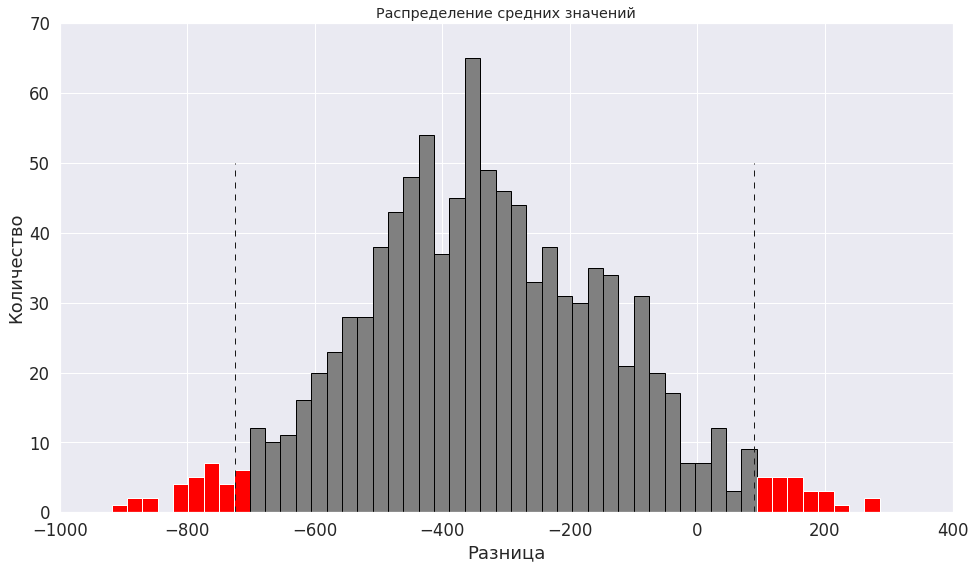

In [38]:
booted_data_ARPPU = get_bootstrap(1000)

---

In [39]:
def bootstrap_pval():
    
    if booted_data_ARPPU['p_value'] > 0.05:
        result = print(f"Значение p-value = {booted_data_ARPPU['p_value'].round(2)}.\n\
Значение больше 0.05. Это значит, что мы принимаем нулевую гипотезу.\n\
Существенных различий между группами нет.")
    else:
        result = print(f"Значение p-value = {booted_data_ARPPU['p_value'].round(2)}. \n\
Значение меньше или равно 0.05. Это значит, что мы не принимаем нулевую гипотезу.\n\
Между группами есть существенные различия.")
        
    return result

In [40]:
bootstrap_pval()

Значение p-value = 0.1.
Значение больше 0.05. Это значит, что мы принимаем нулевую гипотезу.
Существенных различий между группами нет.


---

#### CR

In [41]:
all_metrics[['user_count', 'donaters_count']]

,user_count,donaters_count
control,202103,1928
test,202667,1805


In [42]:
ab_tests_df['paying'] = ab_tests_df['revenue'].apply(lambda x: 'yes' if x > 0 else 'no')
ab_tests_df.head()

,user_id,revenue,testgroup,paying
0,1,0,b,no
1,2,0,a,no
2,3,0,a,no
3,4,0,b,no
4,5,0,b,no


In [43]:
table_cross = pd.crosstab(ab_tests_df.paying, ab_tests_df.testgroup)
table_cross

testgroup,a,b
paying,,
no,200175,200862
yes,1928,1805


In [44]:
stat, p, dof, expected = stats.chi2_contingency(table_cross)
p

0.03647561892312613

p-value < 0,05.
Различия между контрольной и тестовой группой есть.
В контрольной группе конверсия в покупку выше.

---
### Вывод.

Мы проверили исследование на наличие различий между контрольной и тестовой группой.

В ходе исследований выяснилось, что:

- ARPU в двух группах примерно одинаковый, не имеет существенных различий;
- ARPPU в двух группах также примерно одинаковый и не имеет сущетсвенных различий;
- CR в двух группах имеет различия, и в контрольной группе конверсия оказалась больше, чем в тестовой.

---

#### В ходе исследования использовались:

- Критерий Левена — для определения гомогенности дисперсии (если дисперсии гомогенны, можно сделать исключение для проведения t-теста, он же Критерий Стьюдента);
- Критерий Стьюдента (t-тест) — для того, чтобы выяснить есть ли различия между двумя группами;
- Критерий Хи-квадрат — для определения наличия различий между двумя группами.

---

#### Исходя из результатов исследования, можно сделать вывод, что набор акционных предложений в контрольной группе оказался лучше по показателю конверсии в покупку. По остальным метрикам существенных изменений обнаружено не было.

---

## Задание 3. 
---
1. В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?


2. Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

---

#### Пункт 1.

Метрики, которые помогут оценить результаты прошедшего события:
1. ATV (Average Transaction Value) - Поможет провести сегментирование игроков и выстроить ценообразование привелегий.
2. Stickness Rate - Регулярность использования приложения в течение месяца.
3. Churn Rate - Отток пользователей. Возможно, что уровни в событиях слишком трудные или же наоборот слишком легкие или же в событии какой-то баг. Эта метрика будет сигнализировать, что в игре что-то пошло не так.
4. LTV (Lifetime Value) - Покажет общую сумму денег, которую покупатель тратит за всё время, пока пользуется продуктом. Эта метрика также может не за всё время, но и за конкретный промежуток времени (в нашем случае на время события).
5. Conversion funnel (Воронка конверсий) - Сможет сигнализировать о проблемных уровнях, на которых могут отваливаться пользователи.

---
#### Пункт 2.

Для этого потребуется провести новый A/B-тест который покажет результаты за период классического игрового ивента и за период тестового.

Для получения точных результатов исследования понадобятся дополнительные логи:
1. Скачивания приложения.
2. Продолжительность сессии.
3. Уровень пользователя в игре и в игровом событии и история его повышения.
4. Неудачные попытки пользователя пройти уровень.

Для определения успешности введения новой механики понадобятся те же метрики, что и в первом пункте плюс Retention Rate.


---